# 9.9 语义分割和数据集

In [1]:
%matplotlib inline
import time
import torch
import torch.nn.functional as F
import torchvision
import numpy as np
from PIL import Image
from tqdm import tqdm

import sys
sys.path.append("..") 
import d2lzh_pytorch as d2l

print(torch.__version__, torchvision.__version__)

1.2.0 0.4.0a0+6b959ee


## 9.9.2 Pascal VOC2012语义分割数据集

In [2]:
!ls ../../data/VOCdevkit/VOC2012

Annotations        JPEGImages         SegmentationObject
ImageSets          SegmentationClass


In [3]:
# 本函数已保存在d2lzh_pytorch中方便以后使用
def read_voc_images(root="../../data/VOCdevkit/VOC2012", 
                    is_train=True, max_num=None):
    txt_fname = '%s/ImageSets/Segmentation/%s' % (
        root, 'train.txt' if is_train else 'val.txt')
    with open(txt_fname, 'r') as f:
        images = f.read().split()
    if max_num is not None:
        images = images[:min(max_num, len(images))]
    features, labels = [None] * len(images), [None] * len(images)
    for i, fname in tqdm(enumerate(images)):
        features[i] = Image.open('%s/JPEGImages/%s.jpg' % (root, fname)).convert("RGB")
        labels[i] = Image.open('%s/SegmentationClass/%s.png' % (root, fname)).convert("RGB")
    return features, labels # PIL image

In [4]:
voc_dir = "../../data/VOCdevkit/VOC2012"
train_features, train_labels = read_voc_images(voc_dir, max_num=100)

100it [00:01, 54.94it/s]


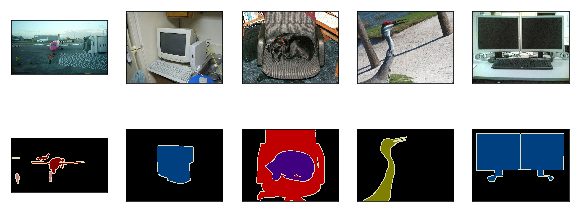

In [5]:
n = 5
imgs = train_features[0:n] + train_labels[0:n]
d2l.show_images(imgs, 2, n);

In [6]:
# 本函数已保存在d2lzh_pytorch中方便以后使用
VOC_COLORMAP = [[0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0],
                [0, 0, 128], [128, 0, 128], [0, 128, 128], [128, 128, 128],
                [64, 0, 0], [192, 0, 0], [64, 128, 0], [192, 128, 0],
                [64, 0, 128], [192, 0, 128], [64, 128, 128], [192, 128, 128],
                [0, 64, 0], [128, 64, 0], [0, 192, 0], [128, 192, 0],
                [0, 64, 128]]
# 本函数已保存在d2lzh_pytorch中方便以后使用
VOC_CLASSES = ['background', 'aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair', 'cow',
               'diningtable', 'dog', 'horse', 'motorbike', 'person',
               'potted plant', 'sheep', 'sofa', 'train', 'tv/monitor']

In [7]:
colormap2label = torch.zeros(256 ** 3, dtype=torch.uint8)
for i, colormap in enumerate(VOC_COLORMAP):
    colormap2label[(colormap[0] * 256 + colormap[1]) * 256 + colormap[2]] = i

# 本函数已保存在d2lzh_pytorch中方便以后使用
def voc_label_indices(colormap, colormap2label):
    """
    convert colormap (PIL image) to colormap2label (uint8 tensor).
    """
    colormap = np.array(colormap.convert("RGB")).astype('int32')
    idx = ((colormap[:, :, 0] * 256 + colormap[:, :, 1]) * 256
           + colormap[:, :, 2])
    return colormap2label[idx]

In [8]:
y = voc_label_indices(train_labels[0], colormap2label)
y[105:115, 130:140], VOC_CLASSES[1]

(tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
         [0, 0, 0, 0, 0, 0, 0, 1, 1, 1],
         [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 0, 0, 0, 1, 1]], dtype=torch.uint8), 'aeroplane')

### 9.9.2.1 预处理数据

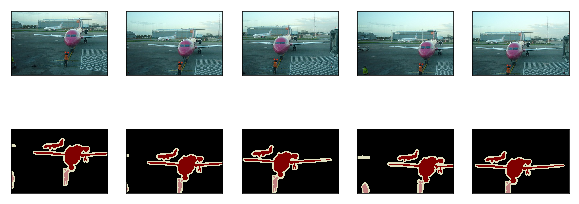

In [9]:
# 本函数已保存在d2lzh_pytorch中方便以后使用
def voc_rand_crop(feature, label, height, width):
    """
    Random crop feature (PIL image) and label (PIL image).
    """
    i, j, h, w = torchvision.transforms.RandomCrop.get_params(
            feature, output_size=(height, width))
    
    feature = torchvision.transforms.functional.crop(feature, i, j, h, w)
    label = torchvision.transforms.functional.crop(label, i, j, h, w)    

    return feature, label

imgs = []
for _ in range(n):
    imgs += voc_rand_crop(train_features[0], train_labels[0], 200, 300)
d2l.show_images(imgs[::2] + imgs[1::2], 2, n);

### 9.9.2.2 自定义语义分割数据集类

In [10]:
# 本函数已保存在d2lzh_pytorch中方便以后使用
class VOCSegDataset(torch.utils.data.Dataset):
    def __init__(self, is_train, crop_size, voc_dir, colormap2label, max_num=None):
        """
        crop_size: (h, w)
        """
        self.rgb_mean = np.array([0.485, 0.456, 0.406])
        self.rgb_std = np.array([0.229, 0.224, 0.225])
        self.tsf = torchvision.transforms.Compose([
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(mean=self.rgb_mean, 
                                             std=self.rgb_std)
        ])
        
        self.crop_size = crop_size # (h, w)
        features, labels = read_voc_images(root=voc_dir, 
                                           is_train=is_train, 
                                           max_num=max_num)
        self.features = self.filter(features) # PIL image
        self.labels = self.filter(labels)     # PIL image
        self.colormap2label = colormap2label
        print('read ' + str(len(self.features)) + ' valid examples')

    def filter(self, imgs):
        return [img for img in imgs if (
            img.size[1] >= self.crop_size[0] and
            img.size[0] >= self.crop_size[1])]

    def __getitem__(self, idx):
        feature, label = voc_rand_crop(self.features[idx], self.labels[idx],
                                       *self.crop_size)
        
        return (self.tsf(feature),
                voc_label_indices(label, self.colormap2label))

    def __len__(self):
        return len(self.features)

### 9.9.2.3 读取数据集

In [11]:
crop_size = (320, 480)
max_num = 100
voc_train = VOCSegDataset(True, crop_size, voc_dir, colormap2label, max_num)
voc_test = VOCSegDataset(False, crop_size, voc_dir, colormap2label, max_num)

100it [00:00, 104.07it/s]
6it [00:00, 56.42it/s]

read 75 valid examples


100it [00:01, 56.74it/s]

read 77 valid examples


In [12]:
batch_size = 64
num_workers = 0 if sys.platform.startswith('win32') else 4
train_iter = torch.utils.data.DataLoader(voc_train, batch_size, shuffle=True,
                              drop_last=True, num_workers=num_workers)
test_iter = torch.utils.data.DataLoader(voc_test, batch_size, drop_last=True,
                             num_workers=num_workers)

In [13]:
for X, Y in train_iter:
    print(X.dtype, X.shape)
    print(y.dtype, Y.shape)
    break

torch.float32 torch.Size([64, 3, 320, 480])
torch.uint8 torch.Size([64, 320, 480])
